In [6]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
# filter some warning messages
warnings.filterwarnings("ignore") 

####################you will need to change some paths here!#####################
#list of input files
filename_bird='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide.csv'
#output files
filename_bird_out='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide_sat_data.csv'
filename_bird_out_netcdf='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide_sat_data.nc'
#################################################################################
#output files
filename_bird_out_final='f:/data/project_data/NASA_biophysical/collocated_data/seabird/NPPSD_GOA_allseabird_wide_sat_clim_data.csv'
filename_bird_out_netcdf_final='f:/data/project_data/NASA_biophysical/collocated_data/seabird/NPPSD_GOA_allseabird_wide_sat_clim_data.nc'
#################################################################################

In [ ]:
#read in csv file in to panda dataframe
ds_bird = pd.read_csv(filename_bird)
#calculate time
tem=np.ones(len(ds_bird),dtype='datetime64[ns]')
for i in range(len(ds_bird)):
    tstr = str(ds_bird.Year[i])+'-'+str(ds_bird.Month[i]).zfill(2)+'-'+str(ds_bird.Day[i]).zfill(2)
    tem[i]=np.datetime64(tstr)
ds_bird['time']=tem
ds_bird

In [ ]:
#just check lat/lon & see looks okay
plt.scatter(ds_bird.Lon,ds_bird.Lat)

# Define function to read in data and put in a dictionary

In [2]:
#define function to get all the data at once, use same years for climatology for all data
def get_data():
    
    #climatology years
    cyr1,cyr2='1993-01-01','2018-12-31'
    
    # CCMP test
    dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_ccmp = ds.sortby(ds.lon)
    ds_ccmp = ds_ccmp.drop('nobs')
    for var in ds_ccmp:
        tem = ds_ccmp[var].attrs
        tem['var_name']='ccmp_'+str(var)
        ds_ccmp[var].attrs=tem
    ds_ccmp_clim = ds_ccmp.sel(time=slice(cyr1,cyr2))
    ds_ccmp_clim = ds_ccmp_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    # AVISO test
    dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_aviso = ds.sortby(ds.lon).drop({'lat_bnds','lon_bnds','crs','err'})
    for var in ds_aviso:
        tem = ds_aviso[var].attrs
        tem['var_name']='aviso_'+str(var)
        ds_aviso[var].attrs=tem
    ds_aviso_clim = ds_aviso.sel(time=slice(cyr1,cyr2))
    ds_aviso_clim = ds_aviso_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)    

    #sst
    dir_pattern_zarr = 'F:/data/sst/cmc/zarr/'
    ds_sst= xr.open_zarr(dir_pattern_zarr)
    ds_sst = ds_sst.drop({'analysis_error','mask','sea_ice_fraction'})
    tem = ds_sst.analysed_sst.attrs
    tem['var_name']='cmc_sst'
    ds_sst.analysed_sst.attrs=tem
    ds_sst_clim = ds_sst.sel(time=slice(cyr1,cyr2))
    ds_sst_clim = ds_sst_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    #get bathymetry from ETOPO1
    fname_topo = 'F:/data/topo/ETOPO1_Ice_g_gmt4.grd'
    ds = xr.open_dataset(fname_topo)
    ds_topo = ds.rename_dims({'x':'lon','y':'lat'}).rename({'x':'lon','y':'lat'})
    tem = ds_topo.z.attrs
    tem['var_name']='etopo_depth'
    ds_topo.z.attrs=tem

    #put data into a dictionary
    data_dict={'aviso':ds_aviso,
               'wnd':ds_ccmp,
               'sst':ds_sst,
              'topo':ds_topo}
    clim_dict={'aviso_clim':ds_aviso_clim,
               'wnd_clim':ds_ccmp_clim,
               'sst_clim':ds_sst_clim}
  
    return data_dict,clim_dict

In [3]:
data,clim = get_data()

# Collocate all data with bird data

In [ ]:
for name in data:
    ds_data=data[name]
    if name=='topo':
        continue
    print('name',name)
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']
        ds_bird[var_tem]=np.ones(len(ds_bird))*np.NaN
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(len(ds_bird)):
        if ds_bird.time[i]<ds_data.time.min():
            continue
        if ds_bird.time[i]>ds_data.time.max():
            continue
        t1,t2 = ds_bird.time[i]-np.timedelta64(24,'h'), ds_bird.time[i]+np.timedelta64(24,'h')
        lat1,lat2=ds_bird.Lat[i]-.5,ds_bird.Lat[i]+.5
        lon1,lon2=ds_bird.Lon[i]-.5,ds_bird.Lon[i]+.5
        tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
        tem = tem.interp(time=ds_bird.time[i],lat=ds_bird.Lat[i],lon=ds_bird.Lon[i])
        #tem = tem.load()
        for var in ds_data:
            var_tem=ds_data[var].attrs['var_name']
            ds_bird[var_tem][i]=tem[var].data
        if int(i/100)*100==i:
            print(i,len(ds_bird))
#at topo info
#interp will create a new 2D array, to avoid that put the lat/lon into dataarrays
ds_topo=data['topo']
new_lat = xr.DataArray(ds_bird.Lat.values, dims='new_dim')
new_lon = xr.DataArray(ds_bird.Lon.values, dims='new_dim')
ds_bird['ETOPO_depth'] = ds_topo.z.interp(lat=new_lat, lon=new_lon,method='nearest')

#output data
ds_bird.to_csv(filename_bird_out)
DS_bird = xr.Dataset.from_dataframe(ds_bird)
DS_bird.to_netcdf(filename_bird_out_netcdf)

# now add clim data

In [4]:
#read in csv file in to panda dataframe
ds_bird = pd.read_csv(filename_bird_out)
#calculate time
tem=np.ones(len(ds_bird),dtype='datetime64[ns]')
for i in range(len(ds_bird)):
    tstr = str(ds_bird.Year[i])+'-'+str(ds_bird.Month[i]).zfill(2)+'-'+str(ds_bird.Day[i]).zfill(2)
    tem[i]=np.datetime64(tstr)
ds_bird['time']=tem
ds_bird

,Unnamed: 0,Unnamed: 0.1,Master.Key,Modified.Platform.Type,Fly.Bird.Method,Year,Month,Day,Julian.Date,Sample.Area,...,aviso_adt,aviso_sla,aviso_ugos,aviso_ugosa,aviso_vgos,aviso_vgosa,ccmp_uwnd,ccmp_vwnd,cmc_sst,ETOPO_depth
0,0,1,00008900289266113069,Large Boat,Snapshot,1989,9,23,266,0.92,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.627558,3.694584,NaN,-13.0
1,1,2,00008900389266114069,Large Boat,Snapshot,1989,9,23,266,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.657751,3.744639,NaN,-20.0
2,2,3,00008900489266115069,Large Boat,Snapshot,1989,9,23,266,0.92,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.706715,3.808849,NaN,-21.0
3,3,4,00008900589266120069,Large Boat,Snapshot,1989,9,23,266,1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.800105,3.906118,NaN,-23.0
4,4,5,00008900689266121069,Large Boat,Snapshot,1989,9,23,266,0.82,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.891196,4.004569,NaN,-20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92733,92733,92734,WOL 2018-07-17 21:57:58,Large Boat,Snapshot,2018,7,17,198,0.58,...,0.454218,0.010080,0.083981,0.099951,-0.065987,-0.034954,5.850998,0.916850,284.683242,-182.0
92734,92734,92735,WOL 2018-07-17 22:08:40,Large Boat,Snapshot,2018,7,17,198,0.58,...,0.454670,0.010279,0.088105,0.105073,-0.069213,-0.038192,5.894030,0.930526,284.706237,-174.0
92735,92735,92736,WOL 2018-07-17 22:19:02,Large Boat,Snapshot,2018,7,17,198,0.57,...,0.454823,0.010547,0.091983,0.109670,-0.069996,-0.038922,5.942175,0.944419,284.728114,-169.0
92736,92736,92737,WOL 2018-07-17 22:28:44,Large Boat,Snapshot,2018,7,17,198,0.59,...,0.454695,0.010891,0.095475,0.113602,-0.068352,-0.037134,5.995787,0.958700,284.751116,-181.0


In [ ]:
for name in clim:
    ds_data=clim[name]
    print('name',name)
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']+'_clim'
        ds_bird[var_tem]=np.ones(len(ds_bird))*np.NaN
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(len(ds_bird)):
        t1,t2 = ds_bird.time[i]-np.timedelta64(24,'h'), ds_bird.time[i]+np.timedelta64(24,'h')
        lat1,lat2=ds_bird.Lat[i]-.5,ds_bird.Lat[i]+.5
        lon1,lon2=ds_bird.Lon[i]-.5,ds_bird.Lon[i]+.5
        tem = ds_data.sel(dayofyear=ds_bird.time[i].dayofyear,lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
        tem = tem.interp(lat=ds_bird.Lat[i],lon=ds_bird.Lon[i])
        for var in ds_data:
            var_tem=ds_data[var].attrs['var_name']+'_clim'
            ds_bird[var_tem][i]=tem[var].data
            
#output data
ds_bird.to_csv(filename_bird_out_final)
DS_bird = xr.Dataset.from_dataframe(ds_bird)
DS_bird.to_netcdf(filename_bird_out_netcdf_final)




name aviso_clim
var aviso_vgosa_clim


In [6]:
ds_data

<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 720, lon: 1440, nv: 2)
Coordinates:
  * lon        (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat        (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * nv         (nv) int32 0 1
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    adt        (dayofyear, lat, lon) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    sla        (dayofyear, lat, lon) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    ugos       (dayofyear, lat, lon) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    ugosa      (dayofyear, lat, lon) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    vgos       (dayofyear, lat, lon) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    vgosa      (dayofyear, lat, lon) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2019-09-11T21:09:34Z
    date_issued:                     2019-09-11T21:09:34Z
    date_modified:                   2019-09-11T21:09:34Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2019-09-11 21:09:35Z: Creation
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        Altika Drifting Phase, Cryosat-2, Haiyan...
    processing_level:                L4
    product_version:                 2019
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    software_version:                6.3_DUACS_DT2018_baseline
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-01-13T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2019-01-13T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [ ]:
%%time
name='aviso'
i=900
#ds_data=data[name]
#tem = ds_data.chunk({'time':len(ds_data.time),'lat':180,'lon':180})
#tem = tem.interp(time=ds_bird.time[i])
#print(len(tem.time.dims))
#print(tem)
#tem = tem.load()
#if len(tem.time.dims)<1:
#    continue
t1 = ds_bird.time[i]-np.timedelta64(24,'h')
t2 = ds_bird.time[i]+np.timedelta64(24,'h')
lat1=ds_bird.Lat[i]-.5
lat2=ds_bird.Lat[i]+.5
lon1=ds_bird.Lon[i]-.5
lon2=ds_bird.Lon[i]+.5
tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2))
tem = tem.interp(time=ds_bird.time[i],lat=ds_bird.Lat[i],lon=ds_bird.Lon[i])
tem = tem.load()


In [ ]:
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']
        ds_bird[var_tem]=np.ones(len(ds_bird))*np.NaN
        ds_bird[var_tem].attrs=ds_data[var].attrs
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']
        ds_bird[var_tem][i]=tem[var].data


In [ ]:
ds_bird[var_tem][i]

In [ ]:
for name in clim:
    ds_data=clim[name]
    print('name',name)
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']+'_clim'
        ds_bird[var_tem]=np.ones(len(ds_bird))*np.NaN
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(100): #len(ds_bird)):
        lat1=ds_bird.Lat[i]-.5
        lat2=ds_bird.Lat[i]+.5
        lon1=ds_bird.Lon[i]-.5
        lon2=ds_bird.Lon[i]+.5
        tem = ds_data.sel(dayofyear=ds_bird.time[i].dayofyear,lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
 #       tem = tem.chunk({'lat':len(ds_data.lat),'lon':len(ds_data.lon)})
        tem = tem.interp(lat=ds_bird.Lat[i],lon=ds_bird.Lon[i])
        for var in ds_data:
            var_tem=ds_data[var].attrs['var_name']+'_clim'
            ds_bird[var_tem][i]=tem[var].data

In [ ]:
ds_bird.index

In [ ]:
tem2 = tem
print(type(tem2))
tem2 = tem2.append(tem, ignore_index=True)
tem2

In [ ]:
        lat1,lat2=ds_bird.Lat[i]-.5,ds_bird.Lat[i]+.5
        lon1,lon2=ds_bird.Lat[i]-.5,ds_bird.Lat[i]+.5
        tem = ds_data.sel(dayofyear=ds_bird.time[i].dayofyear,lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
 #       tem = tem.chunk({'lat':len(ds_data.lat),'lon':len(ds_data.lon)})
        tem2 = tem.interp(lat=ds_bird.Lat[i],lon=ds_bird.Lon[i])
#        for var in ds_data:
#            var_tem=ds_data[var].attrs['var_name']+'_clim'
#            ds_bird[var_tem][i]=tem2[var].data

In [ ]:
tem2

In [ ]:
#    for var in ds_data:
#        var_tem=ds_data[var].attrs['var_name']+'_clim'
#        ds_bird[var_tem]=np.ones(len(ds_bird))*np.NaN
#        ds_bird[var_tem].attrs=ds_data[var].attrs

ds_bird['test']=np.ones(len(ds_bird))*np.nan
ds_bird['test'][i]=tem2[var].data

In [ ]:
ds_bird[var_tem][i]

In [ ]:
    for idy in range(365):
        tem = ds_data.sel(dayofyear=idy).load()
        for i in range(len(ds_bird)):
            if idy==ds_bird.time[i].dayofyear
                tem = tem.interp(lat=ds_bird.Lat[i],lon=ds_bird.Lon[i]).load()
                for var in ds_data:
                    var_tem=ds_data[var].attrs['var_name']+'_clim'
                    ds_bird[var_tem]=tem[var].data


In [ ]:
#test topo
plt.scatter(ds_bird.Lon,ds_bird.Lat,c=ds_bird['ETOPO_depth'])

In [ ]:
plt.scatter(ds_bird.Lon,ds_bird.Lat,c=ds_bird.aviso_sla_clim,vmin=-0.01,vmax=0.01)

In [ ]:
ds_bird.aviso_sla_clim.plot()

In [15]:
fname = 'f:/data/project_data/NASA_biophysical/collocated_data/seabird/NPPSD_GOA_allseabird_wide_sat_and_eddy_data_final.nc'
fname = 'f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_full_eddy_info_envdataall.nc'
ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:             (observation_number: 1830, track: 765)
Coordinates:
  * track               (track) int32 4438 4918 5213 ... 270829 270892 271234
  * observation_number  (observation_number) int32 0 1 2 3 ... 1827 1828 1829
Data variables:
    amplitude           (track, observation_number) float32 ...
    cyclonic_type       (track, observation_number) float64 ...
    lat                 (track, observation_number) float32 ...
    lon                 (track, observation_number) float32 ...
    speed_average       (track, observation_number) float32 ...
    speed_radius        (track, observation_number) float32 ...
    time64              (track, observation_number) datetime64[ns] ...
    time                (track, observation_number) datetime64[ns] ...
    adt                 (track, observation_number) float64 ...
    sla                 (track, observation_number) float64 ...
    ugos                (track, observation_number) float64 ...
    ugosa               (track, observation_number) float64 ...
    vgos                (track, observation_number) float64 ...
    vgosa               (track, observation_number) float64 ...
    chlor_a             (track, observation_number) float32 ...
    uwnd                (track, observation_number) float32 ...
    vwnd                (track, observation_number) float32 ...
    analysed_sst        (track, observation_number) float32 ...
    etopo_depth         (track, observation_number) float64 ...
Attributes:
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Mesoscale Eddies in Altimeter Observations of SLA
    institution:               CNES/CLS in collaboration with Oregon State Un...
    project:                   SSALTO/DUACS
    creator_url:               http://www.aviso.altimetry.fr
    creator_email:             aviso@altimetry.fr
    license:                   http://www.aviso.altimetry.fr/fileadmin/docume...
    summary:                   This dataset contains eddy atlas from two-sate...
    comment:                   Surface product; mesoscale eddies
    input_product_reference:   https://www.aviso.altimetry.fr/en/data/product...
    date_created:              2017-09-22T10:20:17Z
    time_coverage_duration:    P8771D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2017-01-06T00:00:00Z
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    product_version:           1.0

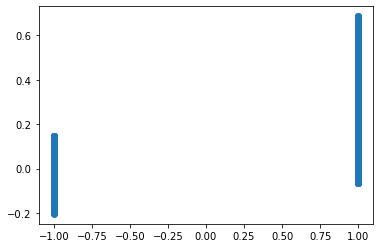

In [18]:
plt.scatter(ds.cyclonic_type,ds.sla)